# scCamAge Pipeline Replication

The scCamAge prediction pipeline starts with raw images, proceeds through segmentation, contouring, and finally prediction. The code needed to be run in a docker anaconda environment. Unfortunately, we can't show the output of the cells, but we will annotate each part to interpret their functions.

In [1]:
### SETUP ###

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import os
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colormaps
import PIL
import cv2
import torch.nn.functional as F
import pandas as pd
import scipy.stats as stats
import random
import shutil

## Segmentation

The first script to run in the pipeline is below. It requires only an input and an output image, and outputs to a directory of the user's choosing. It functions to 'segment' each cell in the entire input frame. In essence, it will return the mask, and outline of every yeast cell that the algorithm detects.

In [ ]:
import opts as opt
import os
import shutil

from mrcnn.my_inference import predict_images
from mrcnn.preprocess_images import preprocess_images
from mrcnn.convert_to_image import convert_to_image, convert_to_imagej

if opt.output_directory != '' and not os.path.isdir(opt.output_directory):
    os.mkdir(opt.output_directory)

if os.path.isdir(opt.output_directory):
    if len(os.listdir(opt.output_directory)) > 0:
        print ("ERROR: Make sure that the output directory to save masks to is empty.")
    else:
        preprocessed_image_directory = opt.output_directory + "/preprocessed_images/"
        preprocessed_image_list = opt.output_directory + "/preprocessed_images_list.csv"
        rle_file = opt.output_directory + "/compressed_masks.csv"
        output_mask_directory = opt.output_directory + "/masks/"
        output_imagej_directory = opt.output_directory + "/imagej/"

        # Preprocess the images
        if opt.verbose:
            print ("\nPreprocessing your images...")
        preprocess_images(opt.input_directory,
                          preprocessed_image_directory,
                          preprocessed_image_list,
                          verbose = opt.verbose)

        if opt.verbose:
            print ("\nRunning your images through the neural network...")
        predict_images(preprocessed_image_directory,
                       preprocessed_image_list,
                       rle_file,
                       rescale = opt.rescale,
                       scale_factor = opt.scale_factor,
                       verbose = opt.verbose)

        if opt.save_masks == True:
            if opt.verbose:
                print("\nSaving the masks...")
            
            if opt.output_imagej == True:
                convert_to_image(rle_file,
                                 output_mask_directory,
                                 preprocessed_image_list,
                                 rescale=opt.rescale,
                                 scale_factor=opt.scale_factor,
                                 verbose = opt.verbose)
                
                convert_to_imagej(output_mask_directory,
                                  output_imagej_directory)
            else:
                convert_to_image(rle_file,
                                 output_mask_directory,
                                 preprocessed_image_list,
                                 rescale=opt.rescale,
                                 scale_factor=opt.scale_factor,
                                 verbose = opt.verbose)

        os.remove(preprocessed_image_list)
        
        if not opt.save_preprocessed:
            shutil.rmtree(preprocessed_image_directory)

        if not opt.save_compressed:
            os.remove(rle_file)

        if not opt.save_masks:
            shutil.rmtree(output_mask_directory)

## Contouring

The next module takes in the segmented output of the last and individually crops cells to form them into the input required for the prediction/training process. The end result will be a folder (defined by the user) filled with crops of single celled images taking up the entire frame. These filepaths, and information stored about the cells such as location within the original image, will be stored in a csv.

In [ ]:
def perform_contour_analysis(dir_raw, dir_mask, dir_contour, out_dir):
    # Create output directory if it doesn't exist
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    # Initialize lists to store contour properties
    Countour_area = []
    Arc_length = []
    Covexity = []
    convexhull = []
    Name = []

    # Loop over files in dir_mask
    for file in sorted(os.listdir(dir_mask)):
        if file.endswith(".jpg"):
            print("Processing file:", file)
            # Read masked image
            mask = cv2.imread(os.path.join(dir_mask, file))
            mask[mask > 0] = 255  # Thresholding
            
            # Find contours
            contours, _ = cv2.findContours(cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Loop over contours
            for i, c in enumerate(contours):
                if cv2.minEnclosingCircle(c)[1] >= 50 and cv2.minEnclosingCircle(c)[1] <= 1000:
                    rect = cv2.boundingRect(c)
                    x, y, w, h = rect
                    if rect[2] <= 50 or rect[3] <= 50:
                        continue
                    if cv2.contourArea(c) >= 1000 and cv2.contourArea(c) <= 100000:
                        if cv2.arcLength(c, True) >= 240 and cv2.arcLength(c, True) <= 20000:
                            # Extract ROI
                            ROI = cv2.imread(os.path.join(dir_raw, file))[y:y+h+10, x:x+w-10]
                            
                            # Append contour properties to lists
                            Countour_area.append(cv2.minEnclosingCircle(c)[1])
                            Arc_length.append(cv2.arcLength(c, True))
                            Covexity.append(cv2.isContourConvex(c))
                            convexhull.append(cv2.convexHull(c))
                            Name.append(os.path.join(dir_contour, '{}_ROI_{}.png'.format(file.split('.')[0], i)))
                            
                            # Save ROI image
                            cv2.imwrite(os.path.join(dir_contour, '{}_ROI_{}.png'.format(file.split('.')[0], i)), ROI)
            
    # Create DataFrame with contour properties
    contour_Data = pd.DataFrame({
        "Countour_Area": Countour_area,
        "Perimeter": Arc_length,
        "Is_Convex": Covexity,
        "Convexhull": convexhull,
        "Name": Name
    })
    
    # Save DataFrame to CSV
    contour_Data.to_csv(os.path.join(out_dir, 'contour_results.csv'), index=False)

# Example usage
if __name__ == "__main__":
    dir_raw = ""  ## input directory path of raw images
    dir_mask = ""  ## output directory path of segmented image/masks
   
    dir_contour = ""   ## new dir file path
    out_dir = ""         ## new dir file path

    perform_contour_analysis(dir_raw, dir_mask, dir_contour, out_dir)

# Prediction

The last module of the pipeline takes in the cropped images and returns a csv containing the predicted age of each image. The csv stores the path of each image and uses it to map to the age. The model is actually a classifier, and returns an age class from 0 to 9, signifying day 2 through 20 (2 day increment).

In [138]:
### To load Ca,Age model
class ImageInceptionResNetV2(nn.Module):
    def __init__(self):
        super(ImageInceptionResNetV2, self).__init__()
        self.image_feature_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
        self.fc = nn.Sequential(
            nn.Linear(in_features=1000, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(),
            nn.Linear(in_features=128, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        inception_outputs = self.image_feature_extractor(x)
        output = inception_outputs
        output = self.fc(output)
        return output


### To prerocess data
def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

### Batch prediction
def batch_predict(model, images):
    model.eval()
    preprocess_transform = get_preprocess_transform()
    transform2 = transforms.Compose([
        transforms.ToTensor(),
    ])
    batch = torch.stack(tuple(transform2(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    logits = model(batch)
    probs = logits#.argmax(dim=1)
    return probs.detach().cpu().numpy()

### For explanability module
def explanation_heatmap(exp, exp_class, output_path=None):
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.colorbar()
    if output_path:
        plt.savefig(output_path)
    else:
        plt.show()

 ### Prediction_model       
def process_image_data(input_path, output_path):
    dirname = os.path.dirname(__file__)
    model_path = os.path.join(dirname, 'Model/model_epoch200.pt')
    bioactivity_model_path = os.path.join(dirname, 'Models/Bioactivity_full_trained_models/rr_TMRE_regression.sav')

    with open(os.path.join(dirname, 'Models/Bioactivity_full_trained_models/rr_TMRE_regression.sav'), 'rb') as file:
        TMRE = pickle.load(file)
        
    with open(os.path.join(dirname, 'Models/Bioactivity_full_trained_models/rr_H2DCFDA_regression.sav'), 'rb') as file:
        H2DCFDA = pickle.load(file)

    with open(os.path.join(dirname, 'Models/Bioactivity_full_trained_models/rr_FM4_46_regression.sav'), 'rb') as file:
        FM4_46 = pickle.load(file)

    with open(os.path.join(dirname, 'Models/Drugs_full_trained_model/rf_MG132_Classification.sav'), 'rb') as file:
        MG132 = pickle.load(file)
        
    with open(os.path.join(dirname, 'Models/Drugs_full_trained_model/rf_Azacytidine_Classification.sav'), 'rb') as file:
        Aza = pickle.load(file)
        
    with open(os.path.join(dirname, 'Models/Drugs_full_trained_model/rf_Etoposide_Classification.sav'), 'rb') as file:
        Etoposide = pickle.load(file)

    for i in os.listdir(input_path):
        
        data3 = pd.DataFrame()
        print(i)
        data = pd.read_csv(os.path.join(input_path, i))
        data2 = data.drop(["Names"], axis=1) #name col, feat col (1-128 list) - 2 cols + 1-128 col, data2 has 128 cols
        
        data2_pred = TMRE.predict(data2)
        data3["Prediction_TMRE_Intensity"] = data2_pred
        
        data2_pred = H2DCFDA.predict(data2)
        data3["Prediction_H2DCFDA_Intensity"] = data2_pred
        
        data2_pred = FM4_46.predict(data2)
        data3["Prediction_FM_Intensity"] = data2_pred
        
        data2_pred = MG132.predict(data2)
        data3["MG132"] = data2_pred
        
        data2_pred = Aza.predict(data2)
        data3["Azacytidine"] = data2_pred
        
        data2_pred = Etoposide.predict(data2)
        data3["Etoposide"] = data2_pred    

        data3["Names"] = data["Names"]
        
        item_name = "_".join(i.split("_")[2:-1])

        print("i:", i)
        print("item_name:", item_name)
        output_file = os.path.join(output_path, "predictions_" + item_name + i.split("_")[2] + '.csv')
        print(output_file) 
        data3.to_csv(output_file, index=False)

def predict_images(input_folder, output_folder, explainability=False, num_features=3, image_features=False, ko_prediction=False):
    # check_and_download_models()
    model = ImageInceptionResNetV2()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    dirname = os.path.dirname(__file__)
    model_path = os.path.join(dirname, 'model_epoch200.pt')
    model.load_state_dict(torch.load(model_path))
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # input_folder = os.path.join(output_folder, 'Test_Images')
    names_images = []
    label = []
    all_prob = []
    test_prob = []
    
    for image_file in os.listdir(input_folder):
        if image_file.endswith('.png') or image_file.endswith('.jpg'):
            image_path = os.path.join(input_folder, image_file)
            image = Image.open(image_path).convert("RGB")
            image = transform(image)
            image = image.unsqueeze(0)  # Add batch dimension

            # Move input tensor to GPU if available
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            image = image.to(device)

            with torch.no_grad():
                output = model(image)

            prediction = output.argmax(dim=1)
            label.append(prediction)
            names_images.append(image_file)

            probabilities = torch.nn.functional.softmax(output, dim=1)
            prediction = output.argmax(dim=1)
            predicted_class = prediction.item()
            predicted_probability = probabilities[0, predicted_class].item()
            all_probabilities = probabilities[0].tolist()
            test_prob.append(predicted_probability)
            all_prob.append(all_probabilities)

    print('*****************Saving Image Predictions start****************')
    Image_predictions = pd.DataFrame()
    Image_predictions["File Name"] = names_images
    Image_predictions["Label"] = pd.DataFrame(label)
    Image_predictions["Predicted_class_prob"] = test_prob
    Image_predictions["All_class_prob"] = all_prob
    Image_predictions.to_csv(os.path.join(output_folder, "Test_Image_predictions.csv"))
    print('*****************End Saving Image Predictions start****************')

Examples of the cropped cells and the format of the prediction can be seen in figure 1 of the final report.

# MRI - Age Prediction Engine

## Preprocessing

The dataset we procured was luckily already very well preprocessed. The images are aligned properly, which eliminates any positional noise that the model might interpret. The images are also already skull stripped, and artifacts have been eliminated. The only thing remaining for us to do is randomize and then split our data into training, validation, and test sets. We'll be taking our non-Demented dataset for training, as it's by far the largest (60k images):

In [21]:
def split_images(root_path, output_path, splits=(0.7, 0.15, 0.15)):
    # storing our image names
    train = []
    val = []
    test = []

    # get all the image names
    images = os.listdir(root_path)

    # shuffle images
    random.shuffle(images)

    # get partition bounds
    split1 = int(splits[0] * len(images))
    split2 = split1 + int(splits[1] * len(images))

    # assign images
    train = images[:split1]
    val = images[split1:split2]
    test = images[split2:]

    # copy files
    os.makedirs(output_path, exist_ok=True)
    for split_name, split_images in zip(['train', 'val', 'test',] ,[train, val, test]):
        split_path = os.path.join(output_path, split_name)
        os.makedirs(split_path, exist_ok=True)
        for f in split_images:
            curr_img_path = os.path.join(root_path, f)
            output_img_path = os.path.join(split_path, f)
            shutil.copy(curr_img_path, output_img_path)

    return len(train), len(val), len(test)

In [22]:
root_path = '/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/NonDemented'
output_path = '/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/split_data'

split_images(root_path, output_path)

(44492, 9534, 9534)

## Architecture

Before we can start training, we need to define our model and the parameters it's going to take in. We also need to design our training protocol. Before we can do that though, we need to format our input data (brain scans) and connect it to our labels (age).

To start, we'll define a custom dataset class that allows us to load our data in an effective way. It also provides us with flexibility if our folder structure should need to change in any way. Luckily, the current folder structure of the non-demented alzheimer's dataset is quite simple. All the data we need is stored in one folder, and the names will map back to the ages stored in a central csv.

In [2]:
class AgeDataset(Dataset):
    def __init__(self, root_dir, age_sheet_path, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.transform = transform
        self.df = pd.read_excel(age_sheet_path)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)

        # get the age and store it here. The 'ID' col of our df is actually just everything before the third '_' in our filenames.
        img_id = '_'.join(img_name.split('_')[:3])
        img_age = df.loc[df['ID']==img_id, 'Age'].values[0]

        # Load image
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(img_age, dtype=torch.float32)

In [3]:
# df containing age assignments
df = pd.read_excel('/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/oasis_cross-sectional-5708aa0a98d82080.xlsx')
#df

age_sheet_path = '/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/oasis_cross-sectional-5708aa0a98d82080.xlsx'

Now let's store all our data using a transform. The transform aptly transforms the data into an input more suited to training. It's pretty minimal here, as all we're doing is reshaping to 224x224 (which is pretty standard for our chosen model), grayscaling, and normalizing the pixel values by 0.5 mean and standard deviation.

Below our transform, we're assign our train, test, and validation datasets. We're then using a DataLoader object (from pytorch) to load in our assigned data. We'll be using a batch size of 32 (due to memory considerations), and only shuffling our training dataset.

Further below that, we've also loaded in the very mild demented, mild demented, and moderately demented datasets. Those won't come into play during training, but they'll be useful when assessing the generalizability of our model.

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/split_data/train', 
                           age_sheet_path=age_sheet_path, transform=transform)
test_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/split_data/test', 
                          age_sheet_path=age_sheet_path, transform=transform)
val_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/split_data/val', 
                         age_sheet_path=age_sheet_path, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# very mild demented
vmd_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/VeryMildDemented/VeryMildDemented',
                         age_sheet_path=age_sheet_path, transform=transform)
vmd_loader = DataLoader(vmd_dataset, batch_size=32, shuffle=False)

# mild demented
md_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/MildDemented/MildDemented',
                         age_sheet_path=age_sheet_path, transform=transform)
md_loader = DataLoader(md_dataset, batch_size=32, shuffle=False)

# moderately demented
mod_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/ModerateDemented/ModerateDemented',
                         age_sheet_path=age_sheet_path, transform=transform)
mod_loader = DataLoader(mod_dataset, batch_size=32, shuffle=False)

Right here we're just making sure that the input that will be fed to the model is of the correct format. The batch size is 32, with 1 input channel, and the image is 224x224.

In [5]:
# confirm filename format to extract age
for img, age in mod_loader:
    print(img.shape, age)
    break

torch.Size([32, 1, 224, 224]) tensor([86., 78., 86., 78., 78., 78., 78., 86., 86., 78., 78., 86., 86., 86.,
        86., 78., 78., 86., 78., 86., 78., 78., 86., 78., 78., 86., 86., 78.,
        78., 86., 78., 78.])


Now it's time to move on to choosing and morphing the model that we'll be training. We've settled on efficientnetb0 after considerable testing. Below, we can print out the unedited model and view its features for editing:

In [6]:
# unedited model
model = models.efficientnet_b0(weights=None)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Now we're getting into the real meat of the architecture. The setup_model() function below has a few purposes. First, it initializes our chosen model (efficientnetb0) without weights, so that we can train it from scratch. Then it changes the input layer to take in one input instead of three (because our images are grayscale and therefore only have one channel as opposed to rgb images). Lastly, the last convolutional layer of our model's classifier needs to be changed to have a single output, since we're going to be doing regression and not classification. We've also increased the dropout in the last layer to help with overfitting, which was an issue in earlier testing.

In [8]:
def setup_model():
    model = models.efficientnet_b0(weights=None)

    # grayscale input
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    
    # regression output
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 1, bias=True)
    # increase dropout to combat overfitting
    model.classifier[0] = nn.Dropout(p=0.5, inplace=True)

    return model

## Training

The training conventions for our model are going to be pretty standard. The main changes that we made are the use of weight decay (also to combat overfitting), and early stopping to save the best states of our model, based on cross-validation loss. Besides that, we'll be using MSE Loss and the Adam optimizer, both pretty standard choices for model training. Other than that, we'll go through batch by batch and call the forward and backward functions. Pytorch will do the rest.

In [9]:
def train(model, train_loader, val_loader, num_epochs=10, lr=1e-4, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else 
                         "mps" if torch.backends.mps.is_available() else
                         "cpu")
    print(f"Using {device}")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # *** TRYING WEIGHT DECAY TO COMBAT OVERFITTING ***

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
            inputs, targets = inputs.to(device), targets.to(device)

            # forward
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs.view(-1), targets)  # flatten for regression
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print training statistics
        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss}')
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), targets)
                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'run2_effnetb0_alz_saved_states/effnetb0_alz_ep{epoch+1}.pth')
            print(f'saved model at {best_val_loss} loss')

        val_losses.append(avg_val_loss)

    print("Done")
    return train_losses, val_losses

## Evaluation Metrics

We also need to define an evaluation function that we can use on the test loader. After we're done training our model and saving its best states, we'll use this to get test statistics about its performance. Mainly, the R-squared and MSE. We've also thrown in MAE and RMSE. MAE is a little more resilient against large outliers.

Additionally, we've written some methods to work with the true labels and predictions from our evaluate function and provide some visual interpretation of them. The scatter function compares the true labels against the predictions, while the histogram function plots the frequency of (prediction - true label) values.

In [10]:
def evaluate(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else 
                         "mps" if torch.backends.mps.is_available() else
                         "cpu")
    model.to(device)
    
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            true_labels.append(targets.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0).flatten()
    true_labels = np.concatenate(true_labels, axis=0).flatten()

    # Compute evaluation metrics
    mae = mean_absolute_error(true_labels, predictions)
    mse = mean_squared_error(true_labels, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_labels, predictions)

    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R2 Score: {r2}')

    return true_labels, predictions

def plot_scatter(true_labels, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(true_labels, predictions, alpha=0.5)
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.axline((0,0),(80,80), label = 'Perfect Match', color='r')
    plt.legend()
    plt.title('Predicted Age vs True Age')
    plt.show()

def plot_error_distribution(true_labels, predictions):
    errors = predictions - true_labels
    mean = np.mean(errors)
    std = stats.sem(errors)
    CI = stats.norm.interval(0.95, loc = mean, scale = std)
    plt.hist(errors, bins=1000, density=True)
    plt.axvline(mean, color = 'r', label=f'Mean: {mean:.2f}')
    plt.axvline(CI[0], color = 'b', linestyle='dashed', label=f'95% CI: [{CI[0]:.2f}, {CI[1]:.2f}]')
    plt.axvline(CI[1], color = 'b', linestyle='dashed')
    plt.xlabel('Prediction - True Age')
    plt.ylabel('Frequency')
    plt.title('Prediction Error Distribution')
    plt.legend(loc = 'upper right')
    plt.show()

In our best training run, we trained our model for 40 epochs and eventually settled on the 11th epoch as the best balance of performance on the cv set and generalizability. We saw that there were epochs that performed better on the cross-validation set, but we were wary of overfitting, and the 11th epoch saved state already performs quite well.

In [75]:
model = setup_model()
train_losses, val_losses = train(model, train_loader, val_loader, num_epochs=20, lr=1e-3)

Using mps


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:50<00:00,  2.14it/s]


Epoch [1/20], Training Loss: 185.58317461569132
Epoch [1/20], Validation Loss: 56.57713151458126
saved model at 56.57713151458126 loss


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:39<00:00,  2.18it/s]


Epoch [2/20], Training Loss: 63.8196821103072
Epoch [2/20], Validation Loss: 36.014158936954985
saved model at 36.014158936954985 loss


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:39<00:00,  2.18it/s]


Epoch [3/20], Training Loss: 41.08140801526419
Epoch [3/20], Validation Loss: 37.773602597665466


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:44<00:00,  2.16it/s]


Epoch [4/20], Training Loss: 30.560901831757842
Epoch [4/20], Validation Loss: 25.892833743319414
saved model at 25.892833743319414 loss


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:39<00:00,  2.17it/s]


Epoch [5/20], Training Loss: 25.17245842620334
Epoch [5/20], Validation Loss: 32.697822221973595


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:36<00:00,  2.19it/s]


Epoch [6/20], Training Loss: 20.95645631259504
Epoch [6/20], Validation Loss: 17.030953300079243
saved model at 17.030953300079243 loss


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:35<00:00,  2.19it/s]


Epoch [7/20], Training Loss: 19.87924566515738
Epoch [7/20], Validation Loss: 18.973953700705664


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:44<00:00,  2.16it/s]


Epoch [8/20], Training Loss: 18.24131864270746
Epoch [8/20], Validation Loss: 10.426785895488406
saved model at 10.426785895488406 loss


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:45<00:00,  2.15it/s]


Epoch [9/20], Training Loss: 15.120890340386836
Epoch [9/20], Validation Loss: 12.172032525875425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:48<00:00,  2.14it/s]


Epoch [10/20], Training Loss: 13.222440936083762
Epoch [10/20], Validation Loss: 16.245238799376775


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:39<00:00,  2.17it/s]


Epoch [11/20], Training Loss: 16.06650198148704
Epoch [11/20], Validation Loss: 10.941601622024638


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:49<00:00,  2.14it/s]


Epoch [12/20], Training Loss: 10.526577160908626
Epoch [12/20], Validation Loss: 5.479780634777658
saved model at 5.479780634777658 loss


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:49<00:00,  2.14it/s]


Epoch [13/20], Training Loss: 13.30646638181208
Epoch [13/20], Validation Loss: 8.839335387185116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:39<00:00,  2.17it/s]


Epoch [14/20], Training Loss: 10.617213264461219
Epoch [14/20], Validation Loss: 7.126629250961662


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:48<00:00,  2.15it/s]


Epoch [15/20], Training Loss: 10.13502093324723
Epoch [15/20], Validation Loss: 13.34157684905417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:38<00:00,  2.18it/s]


Epoch [16/20], Training Loss: 10.581414524725579
Epoch [16/20], Validation Loss: 5.5045505850107075


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:41<00:00,  2.17it/s]


Epoch [17/20], Training Loss: 9.737840751192708
Epoch [17/20], Validation Loss: 6.52278775896802


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:38<00:00,  2.18it/s]


Epoch [18/20], Training Loss: 8.698562304978743
Epoch [18/20], Validation Loss: 6.991315692863209


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [11:28<00:00,  2.02it/s]


Epoch [19/20], Training Loss: 7.843630540722313
Epoch [19/20], Validation Loss: 9.567983377299853


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [11:33<00:00,  2.00it/s]


Epoch [20/20], Training Loss: 8.659289337250074
Epoch [20/20], Validation Loss: 11.176484126772657
Done


([185.58317461569132,
  63.8196821103072,
  41.08140801526419,
  30.560901831757842,
  25.17245842620334,
  20.95645631259504,
  19.87924566515738,
  18.24131864270746,
  15.120890340386836,
  13.222440936083762,
  16.06650198148704,
  10.526577160908626,
  13.30646638181208,
  10.617213264461219,
  10.13502093324723,
  10.581414524725579,
  9.737840751192708,
  8.698562304978743,
  7.843630540722313,
  8.659289337250074],
 [56.57713151458126,
  36.014158936954985,
  37.773602597665466,
  25.892833743319414,
  32.697822221973595,
  17.030953300079243,
  18.973953700705664,
  10.426785895488406,
  12.172032525875425,
  16.245238799376775,
  10.941601622024638,
  5.479780634777658,
  8.839335387185116,
  7.126629250961662,
  13.34157684905417,
  5.5045505850107075,
  6.52278775896802,
  6.991315692863209,
  9.567983377299853,
  11.176484126772657])

# Evaluation

In this next module we're visualizing the stored train and cross-validation losses from our training process. We can see that the train and validation loss both decrease rapidly and stay low, which is encouraging. In previous iterations, we saw a rapid decrease in cv-loss, but an exponential increase later on, which was highly indicative of overfitting. Visualizing our model's metrics like this allow us to be cognizant of performance and ultimately develop a better model.

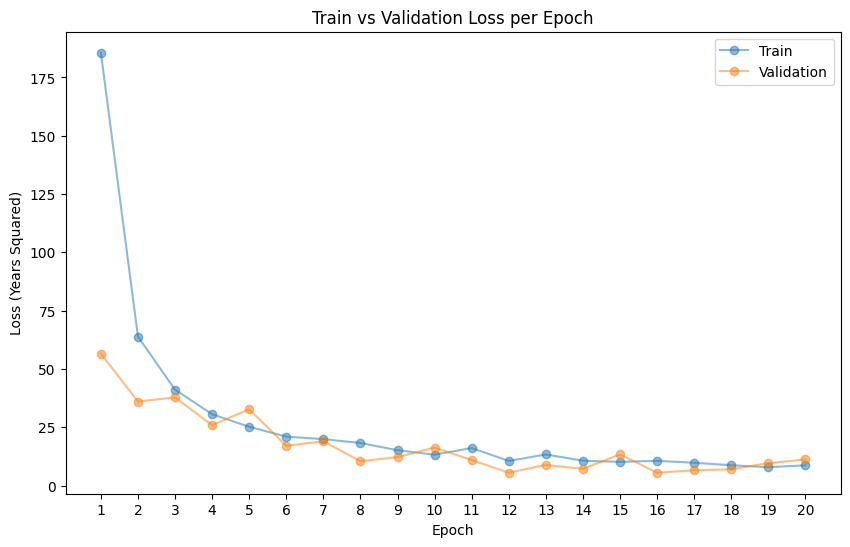

In [147]:
# example run train/val losses
train_losses = [185.58, 63.82, 41.08, 30.56, 25.17, 20.96, 19.88, 18.24, 15.12, 13.22, 16.07, 10.53, 13.31, 10.62, 10.14, 10.58, 9.74, 8.70, 7.84, 8.66] 
val_losses = [56.58, 36.01, 37.77, 25.89, 32.70, 17.03, 18.97, 10.43, 12.17, 16.25, 10.94, 5.48, 8.84, 7.13, 13.34, 5.50, 6.52, 6.99, 9.57, 11.18]

def plot_train_val_loss(train_losses, val_losses):
    steps = list(range(1, 21))
    plt.figure(figsize=(10, 6))
    plt.plot(steps, train_losses, '-o', label='Train', alpha=0.5)
    plt.plot(steps, val_losses, '-o', label='Validation', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Years Squared)')
    plt.legend()
    plt.xticks(steps)
    plt.title('Train vs Validation Loss per Epoch')
    plt.show()

plot_train_val_loss(train_losses, val_losses)

Let's get some test statistics and figures on our model's performance on the test set:

In [148]:
### LOAD OUR BEST CHOSEN STATE
model = setup_model()
model.load_state_dict(torch.load('run1_effnetb0_alz_saved_states/effnetb0_alz_ep11.pth', weights_only=True))

<All keys matched successfully>

In [134]:
# PRINT TEST STATISTICS
true_labels, predictions = evaluate(model, test_loader)

Mean Absolute Error (MAE): 1.96260404586792
Mean Squared Error (MSE): 7.98716926574707
Root Mean Squared Error (RMSE): 2.8261580397683126
R2 Score: 0.986268162727356


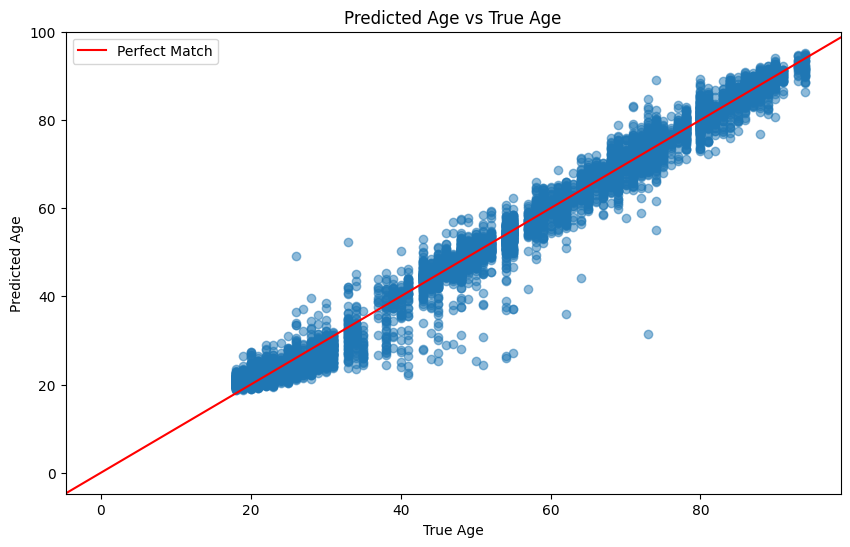

In [135]:
plot_scatter(true_labels, predictions)

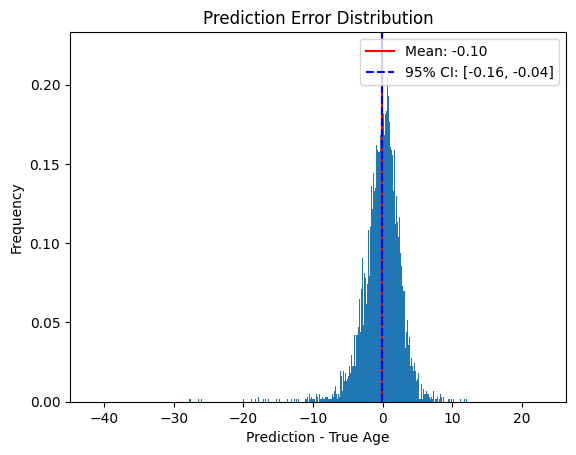

In [136]:
plot_error_distribution(true_labels, predictions)

Let's go through the same evaluation process for our model, but on the moderately demented dataset:

In [26]:
model = setup_model()
model.load_state_dict(torch.load('run1_effnetb0_alz_saved_states/effnetb0_alz_ep11.pth', weights_only=True))

<All keys matched successfully>

In [27]:
mod_true_labels, mod_predictions = evaluate(model, vmd_loader)

Mean Absolute Error (MAE): 6.995109558105469
Mean Squared Error (MSE): 81.36206817626953
Root Mean Squared Error (RMSE): 9.020092470494387
R2 Score: -0.6225926876068115


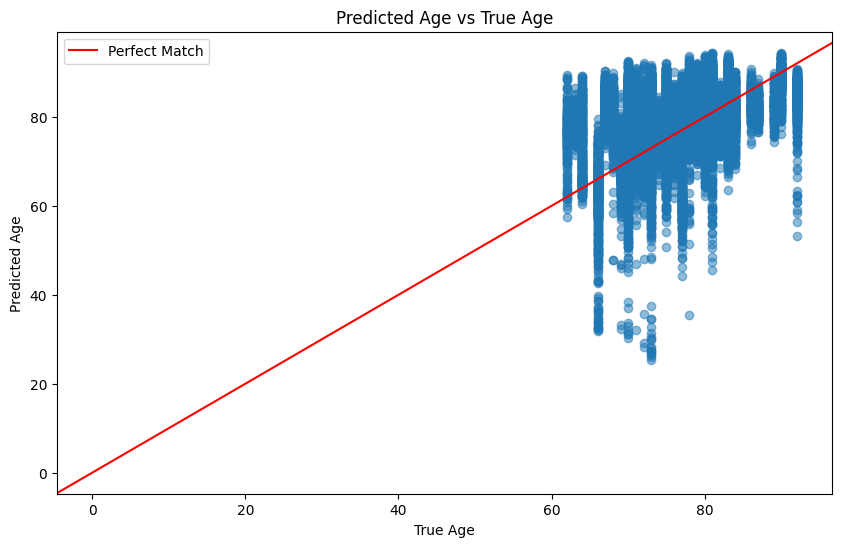

In [30]:
plot_scatter(mod_true_labels, mod_predictions)

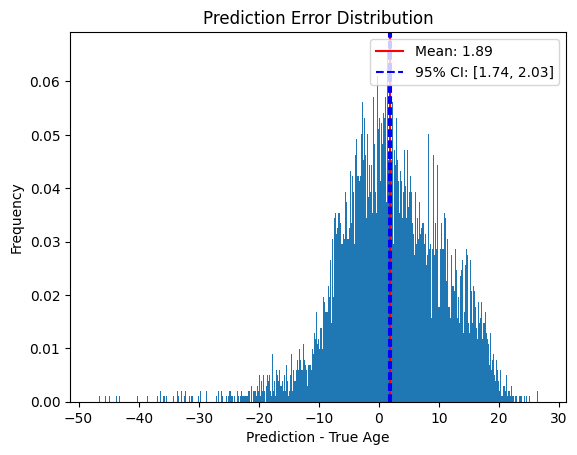

In [29]:
plot_error_distribution(mod_true_labels, mod_predictions)

# Interpretability

All of these test statistics are great, but sometimes, the nature of deep learning models leave us a little wanting in terms of the 'how/why' of things. In the following section, we're going to implement and apply a technique that will allow us to see a little more closely under the hood of our model, and interpret what it's actually looking at in a way that we are able to understand. The method is called Gradient-weighted Class Activation Mapping, or Grad-CAM for short.

The first thing we need to do is write a function that will transform an individual image in the same way that our train loading procedure did. We have to grayscale, resize, and normalize. Our predict image function loads up our model and data onto our memory, and then runs the prediction. We'll need that too.

In [5]:
###### INTERPRETABILITY ######

def prep_img(img_path):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    image = Image.open(img_path).convert('L')
    image = transform(image).unsqueeze(0) # unsqueeze(0) for batch dim
    return image

def pred_img(model, img_tensor):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else 
                         "mps" if torch.backends.mps.is_available() else
                         "cpu")
    model.to(device)
    img_tensor = img_tensor.to(device)
    return model(img_tensor)

Below is our implementation of Grad-CAM. Grad-CAM finds the gradient of the most dominant logit with respect to the *latest* activation map of the model. In other words, it relies on the fact that the last convolutional layer is going to contain some information (in the form of encoded features) that eventually convinced the model to make the choice it did. Our job is to capture those encoded features, and transform them into a gradient that we can look at.

To do this, we're making use of a great implementation found [here](https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569/). The author (Vinícius Almeida) utilizes a neat pytorch feature called hooks - functions that allow us to process information going through the model during the forward and backward pass. We're going to attach these hooks to the last convolutional layer in our model (if a refresher is needed on the architecture, we printed out the entire structure above). After that, we'll pool the resulting gradient, average the channels, and then overlay it on our original image. The result will show us where our model is giving the most attention.

In [6]:
### grad-cam pipeline ###
def run_grad_cam(model, image_path):
    gradients = None
    activations = None
    
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output
        print('bhook')
    
    def forward_hook(module, args, output):
        nonlocal activations
        activations = output
        print('fhook')
    
    # target_layer = model.features[8][0] (?)
    backward_hook = model.features[8][0].register_full_backward_hook(backward_hook, prepend=False)
    forward_hook = model.features[8][0].register_forward_hook(forward_hook, prepend=False)

    # preprocess image
    image = prep_img(image_path)

    output = pred_img(model, image)
    print(f'prediction: {output.item()}')
    output.backward()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients[0], dim=[0,2,3])
    
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim=1).squeeze() # average channels
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap) # normalize
    # uncomment to show raw heatmap
    #plt.matshow(heatmap.detach())

    # remove hooks
    backward_hook.remove()
    forward_hook.remove()
    
    # setup
    fig, ax = plt.subplots()
    ax.axis('off')
    
    # original image
    ax.imshow(to_pil_image(image.squeeze(1), mode='L'), cmap='gray')
    
    # heatmap
    overlay = to_pil_image(heatmap.detach(), mode='F').resize((224,224), resample=PIL.Image.BICUBIC)
    
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    
    # plot heatmap on same axis
    ax.imshow(overlay, alpha=0.35, interpolation='nearest', extent=[0, 224, 224, 0])
    
    plt.show()

fhook
prediction: 18.86626434326172
bhook


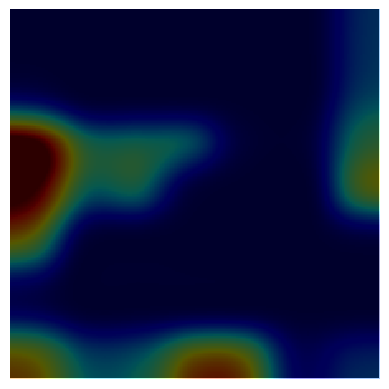

In [20]:
# example usage
image_path = '/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/VeryMildDemented/VeryMildDemented/OAS1_0217_MR1_3.nii_slice_41.png'
run_grad_cam(model, image_path)

Above, the red areas indicate the areas of highest focus for the model, while blue indicates lowest.

In [11]:
model = setup_model()
model.load_state_dict(torch.load('run1_effnetb0_alz_saved_states/effnetb0_alz_ep11.pth', weights_only=True))

<All keys matched successfully>

In [19]:
vmd_fpath = '/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/VeryMildDemented/VeryMildDemented'
for f in os.listdir(vmd_fpath):
    if f.endswith('.png'):
        img_path = os.path.join(vmd_fpath, f)
        image = prep_img(img_path)
        pred = pred_img(model, image).item()
        if pred < 40:
            print(f)

OAS1_0094_MR1_1.nii_slice_165.png
OAS1_0094_MR1_1.nii_slice_171.png
OAS1_0374_MR1_4.nii_slice_129.png
OAS1_0094_MR1_4.nii_slice_166.png
OAS1_0094_MR1_4.nii_slice_172.png
OAS1_0217_MR1_3.nii_slice_40.png
OAS1_0217_MR1_3.nii_slice_54.png
OAS1_0217_MR1_3.nii_slice_55.png
OAS1_0217_MR1_3.nii_slice_41.png
OAS1_0094_MR1_4.nii_slice_173.png
OAS1_0374_MR1_4.nii_slice_128.png
OAS1_0094_MR1_1.nii_slice_170.png
OAS1_0217_MR1_4.nii_slice_59.png
OAS1_0217_MR1_3.nii_slice_57.png
OAS1_0217_MR1_3.nii_slice_43.png
OAS1_0217_MR1_3.nii_slice_249.png
OAS1_0217_MR1_3.nii_slice_248.png
OAS1_0217_MR1_3.nii_slice_42.png
OAS1_0217_MR1_3.nii_slice_56.png
OAS1_0374_MR1_1.nii_slice_128.png
OAS1_0217_MR1_4.nii_slice_58.png
OAS1_0094_MR1_1.nii_slice_167.png
OAS1_0217_MR1_4.nii_slice_64.png
OAS1_0217_MR1_4.nii_slice_48.png
OAS1_0217_MR1_4.nii_slice_60.png
OAS1_0217_MR1_3.nii_slice_52.png
OAS1_0217_MR1_3.nii_slice_46.png
OAS1_0217_MR1_3.nii_slice_47.png
OAS1_0217_MR1_3.nii_slice_53.png
OAS1_0217_MR1_4.nii_slice_61.pn

KeyboardInterrupt: 